Building Text Classifier on IMDB Reviews.

This loosely follows [Chapter 2](https://github.com/nlp-with-transformers/notebooks/blob/main/02_classification.ipynb) of [Natural Language Processing with Transformers, by Tunstall, von Werra and Wolf](https://www.oreilly.com/library/view/natural-language-processing/9781098103231/) 

The [State of the Art](https://paperswithcode.com/sota/text-classification-on-imdb) test accuracy is currently around 97%.
In the fastai book they [train a model](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb) to 94.3%, and in the [ULMFiT](https://arxiv.org/abs/1801.06146) paper with more work they report 95.4%.

# Get the data

The data is originally from [Learning Word Vectors for Sentiment Analysis, Mass et al.](https://aclanthology.org/P11-1015/).

> We constructed a collection of 50,000 reviews from IMDB, allowing no more than 30 reviews per movie.
> The constructed dataset contains an even number of positive and negative reviews, so randomly guessing yields 50% accuracy.
> Following previous work on polarity classification, we consider only highly polarized reviews.
> A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10.
> Neutral reviews are not included in the dataset.

It also includes some unlabeled examples from the neutral reviews:

> We train a variant of our model which uses 50,000 unlabeled reviews in addition to the labeled set of 25,000 reviews.
> The unlabeled set of reviews contains neutral reviews as well as those which are polarized as found in the labeled set.

The dataset is hosted on [Huggingface Datasets](https://huggingface.co/datasets/imdb) and we will get it from there.

In [1]:
from datasets import load_dataset

imdb = load_dataset("imdb")

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

# Make a validation set

There is no validation split, but it's useful for checking the model as we go, so let's create one.
Note that I don't set any seeds so this will be non-deterministic.

In [3]:
val_prop = 0.1

imdb_train_val = imdb["train"].train_test_split(test_size=val_prop)

In [4]:
imdb["train"] = imdb_train_val["train"]
imdb["valid"] = imdb_train_val["test"]

In [5]:
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 22500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 2500
    })
})

## Inspect the data

Notice the text have some `<br />` strings.

In [6]:
for idx in range(4):
    row = imdb['train'][idx]
    print(row['label'])
    print(row['text'])
    print()

0
I just finished watching Going Overboard. I have to say that we should send every copy of this film to Iraq and make them watch. I even tried to get a blind women to watch this and she turned it off in like 20 min. Adam Sandler could not find a better project than this? As for the writing, if thats what you want to call it, those responsible should be forced to watch this movie forever in Hell!! I believe that somewhere I read that the budget for this film was $10,000 and they were way under. Did Wallmart get a good deal on this? Every store has a big huge bin of this crap sitting on the sales floor. The only good thing about this movie is you can use the DVD as a coaster, or trade it to a friend, but then they might not be your friend anymore!!

1
Oliver! the musical is a favorite of mine. The music, the characters, the story. It all just seems perfect. In this rendition of the timeless classic novel turned stage musical, director Carol Reed brings the Broadway hit to life on the mo

## HTML Tags

Let's look into the HTML Tags.
While you can't parse HTML with a regular expression, we can get a rough idea of the tags.

In [7]:
import re


HTML_TAG_RE = re.compile('(<[^<]*?>)')



In [8]:
from collections import Counter

html_tag_count = Counter()
for text in imdb['train']['text']:
    tags = HTML_TAG_RE.findall(text)
    html_tag_count.update(tags)

Almost all the tags are exactly `<br />`

In [9]:
topn = 5


for k,v in sorted(html_tag_count.items(), key=lambda x: x[-1], reverse=True)[:topn]:
    print(f'{k:10} {v} occurances')

<br />     91860 occurances
<i>        7 occurances
</i>       7 occurances
<sigh>     1 occurances
<hr>       1 occurances


Let's add some logic to remove these tags batchwise

In [10]:
def remove_break_tags(text):
    return text.replace('<br />', '\n')

def preprocess(batch):
    batch['text'] = remove_break_tags(batch['text'])
    return batch

In [11]:
assert remove_break_tags('for myself.<br /><br />The plot <br />') == 'for myself.\n\nThe plot \n'

In [12]:
assert imdb['train'].map(preprocess)[0]['text'] == remove_break_tags(imdb['train'][0]['text'])

assert imdb['train'].map(preprocess)[0]['label'] == imdb['train'][0]['label']

0ex [00:00, ?ex/s]

## Label distribution

As described the training set is 50/50 positive and negative.
The unsupervised doesn't have any labels.

In [13]:
from collections import Counter

for split in imdb:
    counts = Counter(imdb[split]['label'])
    print(f'{split}: {counts}')

train: Counter({0: 11292, 1: 11208})
test: Counter({0: 12500, 1: 12500})
unsupervised: Counter({-1: 50000})
valid: Counter({1: 1292, 0: 1208})


# Text Length

In [14]:
splits = ['train', 'unsupervised', 'valid']

In [15]:
import pandas as pd

df = pd.concat([pd.DataFrame(imdb[split]).assign(split=split) for split in splits])

In [16]:
df['num_words'] = df.text.str.split().str.len()

Whether you like boxplots or violin plots: most of the texts are likely to fit into 512 tokens-ish, but a small proportion (~20%?) will need to be truncated.

<AxesSubplot:title={'center':'num_words'}, xlabel='[label, split]'>

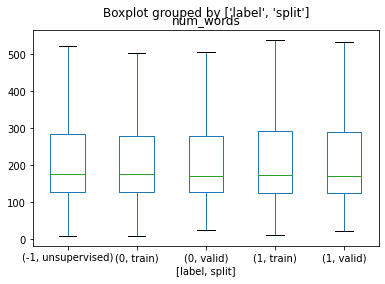

In [17]:
df.boxplot('num_words', by=['label', 'split'], showfliers=False, grid=False)

<AxesSubplot:xlabel='label', ylabel='num_words'>

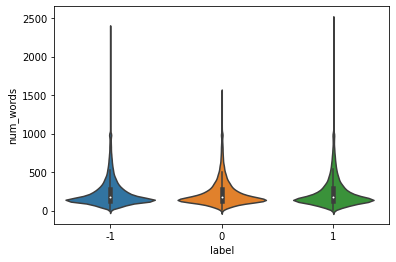

In [18]:
import seaborn as sns
sns.violinplot(x='label', y='num_words', data=df)

## Uniqueness

A small proportion of the rows are duplicate but mostly unique.

It seems if the text is the same then the whole row including the label is the same.

In [19]:
%%time
for split in imdb:
    print(f"{split}: {len(imdb[split])} texts, {len(set(imdb[split]['text']))} unique texts, {len(set(tuple(row.items()) for row in imdb[split]))} unique rows")

train: 22500 texts, 22418 unique texts, 22418 unique rows
test: 25000 texts, 24801 unique texts, 24801 unique rows
unsupervised: 50000 texts, 49507 unique texts, 49507 unique rows
valid: 2500 texts, 2499 unique texts, 2499 unique rows
CPU times: user 7.1 s, sys: 34.1 ms, total: 7.14 s
Wall time: 7.13 s


They are mostly disjoint between splits; there's a tiny amount of leakage.

In [20]:
for split in imdb:
    for other_split in imdb:
        if split > other_split:
            num_common_text = len(set(imdb[split]['text']).intersection(imdb[other_split]['text']))
            print(f'{split}, {other_split}: {num_common_text} in common')

train, test: 111 in common
unsupervised, train: 324 in common
unsupervised, test: 266 in common
valid, train: 13 in common
valid, test: 12 in common
valid, unsupervised: 32 in common


# Tokenization

In [21]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Let's see how the tokenizer handles the `<br />` characters.

In [22]:
text = "Barry Mackenzie is lovable.<br /><br />It's chock a block"
text

"Barry Mackenzie is lovable.<br /><br />It's chock a block"

In [23]:
token_ids = tokenizer(text)['input_ids']
tokens = tokenizer.convert_ids_to_tokens(token_ids)
tokens

['[CLS]',
 'barry',
 'mackenzie',
 'is',
 'lo',
 '##vable',
 '.',
 '<',
 'br',
 '/',
 '>',
 '<',
 'br',
 '/',
 '>',
 'it',
 "'",
 's',
 'cho',
 '##ck',
 'a',
 'block',
 '[SEP]']

It's better after removal

In [24]:
text = remove_break_tags(text)
token_ids = tokenizer(text)['input_ids']
tokens = tokenizer.convert_ids_to_tokens(token_ids)
tokens

['[CLS]',
 'barry',
 'mackenzie',
 'is',
 'lo',
 '##vable',
 '.',
 'it',
 "'",
 's',
 'cho',
 '##ck',
 'a',
 'block',
 '[SEP]']

Tokenizing the whole text

In [25]:
def tokenize_text(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

Here we tokenize everything at once.
Since we're padding the text all the texts in each split have the same size.
It could be more efficient to process the smaller texts together separately.

In [26]:
imdb_encoded = imdb.map(tokenize_text, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [27]:
imdb_encoded.set_format('torch', ['input_ids', 'attention_mask', 'label'])

If the `attention_mask` is full it's either exactly the maximum length or over.
So checking then this is the `model_max_length` gives a slight overestimate of the texts that are truncated.

In [28]:
for split in splits:
    frac_texts_of_max_len = (imdb_encoded[split]['attention_mask'].sum(axis=1) == tokenizer.model_max_length).sum() / len(imdb_encoded[split])
    print(f'{split}: {frac_texts_of_max_len:0.1%} of texts are maybe truncated')

train: 14.9% of texts are maybe truncated
unsupervised: 14.9% of texts are maybe truncated
valid: 14.8% of texts are maybe truncated


# Fine Tune Model

In [29]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [30]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Define metric; namely accuracy

In [31]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds)
    }

In [32]:
from transformers import TrainingArguments

batch_size = 16
logging_steps = len(imdb["train"]) // batch_size
model_name = f'{model_ckpt}-finetuned-imdb'
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    report_to="none",
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error",
)

In [33]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=imdb_encoded["train"],
    eval_dataset=imdb_encoded["valid"],
    tokenizer=tokenizer,
)

We're getting a validation accuracy of 92.5% without domain adaptation.
Let's look into the results.

In [34]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy
1,0.268000,0.212515,0.917200
2,0.149500,0.263180,0.920800


TrainOutput(global_step=2814, training_loss=0.20861409732564892, metrics={'train_runtime': 1317.3872, 'train_samples_per_second': 34.159, 'train_steps_per_second': 2.136, 'total_flos': 5961032939520000.0, 'train_loss': 0.20861409732564892, 'epoch': 2.0})

## Inspect Results

In [35]:
preds_output = trainer.predict(imdb_encoded["valid"])

In [36]:
preds_output.metrics

{'test_loss': 0.2631796896457672,
 'test_accuracy': 0.9208,
 'test_runtime': 24.0446,
 'test_samples_per_second': 103.973,
 'test_steps_per_second': 6.53}

In [37]:
import numpy as np

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = imdb_encoded["valid"]["label"]

## Confusion Matrix

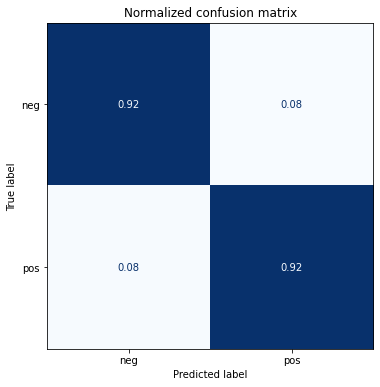

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from matplotlib import pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
plot_confusion_matrix(y_preds, y_valid, labels=["neg", "pos"])

## Top Losses

Look at the predictions with highest loss to understand the model

In [39]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
        
    return {
        "loss": loss.cpu().numpy(),
        "predicted_label": pred_label.cpu().numpy(),
           }

In [40]:
imdb_encoded["valid"] = imdb_encoded["valid"].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/157 [00:00<?, ?ba/s]

In [41]:
imdb_encoded.set_format("pandas")

In [42]:
df_valid = imdb_encoded["valid"][:][["text", "label", "loss", "predicted_label"]]

The top 4 all seem like negative reviews to me; I agree with the model.

In [43]:
for idx, row in df_valid.sort_values('loss', ascending=False).head(5).iterrows():
    print(f'Actual {row.label}, predicted {row.predicted_label} with loss {row.loss}')
    print(row.text)
    print()

Actual 1, predicted 0 with loss 5.955411911010742
I was really excited about seeing this film. I thought finally Australia had made a good film.. but I was wrong.<br /><br />This was the most pathetic attempt at a slasher film ever. I feel sorry for Molly Ringwald having to come all the way to Australia to make an awful movie.<br /><br />The acting was terrible (especially that Australian guy who was trying to speak in an American accent), and the plot was also pretty bad.<br /><br />When I first heard about this film coming out, I thought that the title was pathetic (because it sounds like the cheesy film "Stab" in Scream 2), but I was willing to let it slide if it was a good movie.<br /><br />WARNING!!! MAJOR SPOILERS!!!<br /><br />Probably the worst thing about the film was the ending. I was expecting a big surprise about who the killer was.. but the killer wasn't even human.. which turned this realistic slasher film into an awful horror movie.<br /><br />Don't see this film.. you'l

Borderline predictions; there's definite room for improvement here.

In [44]:
for idx, row in df_valid.query('label != predicted_label').sort_values('loss').head(5).iterrows():
    print(f'Actual {row.label}, predicted {row.predicted_label} with loss {row.loss}')
    print(row.text)
    print()

Actual 1, predicted 0 with loss 0.7124398350715637
**SPOILERS** Since the disappearance at sea of her favorite niece Phyllis murder mystery writer Abigail Mitchell, Ruth Gordon, has strong suspicions that it was Phyllis' husband Edmund Galvin, Charles Frank, who was responsible for her death. In fact Abigail is convinced that he murdered her and made it look like a tragic accident.<br /><br />Knowing that there's no evidence to have Edmund arrested for Phyillis' death and deciding to take the law into her own hands Abigail cooks up this elaborate plan to do him in and make it look, like Phyllis' death, a tragic accident. Getting Edmund to secretly come over to her mansion to give him the combination to her walk-in safe, as she's about to leave on vacation for New York City, Abigail tricks him into going inside locking the startled and surprised Edmund in. With the safe being soundproof nobody at the mansion the butler maid and Abigail's personal secretary Veronica, Mariette Hartley, he

# Domain Adaptation

The next step would be Domain Adaptation, as in the [HuggingFace Course](https://huggingface.co/course/chapter7/3?fw=pt), followed by fine tuning the language model.

It would be worth doing this in a future iteration.